In [1]:
import pandas as pd

# File paths for input files
file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/train_reg.csv"  # Path to the first CSV file
file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

# Output file
output_file = "input/train_reg_nofilter_wIC50.csv"

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure only Molecule ChEMBL ID and IC50 columns are used from file2
df2 = df2[["Molecule ChEMBL ID", "-logIC50"]]  # Adjust "IC50" to the actual column name in file2
#df2 = df2[["Molecule ChEMBL ID", "Potency"]]  # Adjust "IC50" to the actual column name in file2

# Merge the two files based on the "Molecule ChEMBL ID" column, keeping all rows in df1
merged_df = pd.merge(df1, df2, on="Molecule ChEMBL ID", how="left")  # Use "left" join to keep all rows from file1

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

print(f"Merged file saved to {output_file}")


Merged file saved to input/train_reg_nofilter_wIC50.csv




This script performs Factor analysis (FA) for dimensionality reduction and feature selection on the regression training data set of molecular descriptors. 

Dimensionality Reduction with FA:
Uses PCA to compute eigenvalues for all components to visualize variance explained.
Outputs a scree plot showing the variance explained by each principal component.
Select number of components based on the elblow of the scree plot (e.g. 15) 

Factor Loadings and Feature Selection:
Extracts factors and sorts them by absolute values.
Dynamically selects features using a threshold based on the mean and standard deviation of absolute loadings.
Saves sorted loadings and selected features to CSV files for training model (we eventually chose reduced features from PCA in this project since it seems to select more relevant features)


Visualizes the pairs of principal components colored by Potency categories (High, Medium, Low).


Explained Variance by Factor: [0.06699373 0.06698543 0.06697222 0.06693059 0.06689914 0.06689704
 0.0668523  0.06678036 0.06674763 0.06662391 0.06652914 0.06639468
 0.06629354 0.06609599 0.06600431]
Number of factors selected: 15
Factor Loadings:
                         Factor1   Factor2   Factor3   Factor4   Factor5  \
PMI1                  -0.782006 -0.308524 -0.341153  0.300693 -0.017891   
PMI2                  -0.465561  0.795793 -0.227990 -0.050443 -0.110325   
PMI3                  -0.575278  0.708951 -0.279889  0.102969 -0.083682   
Asphericity            0.419705  0.862676  0.038393 -0.107887  0.034101   
Eccentricity           0.315990  0.794276 -0.048955 -0.070792  0.128079   
...                         ...       ...       ...       ...       ...   
saturatedHeterocycles  0.021034  0.259339  0.058020 -0.134382  0.099683   
satureatedRings       -0.214099  0.111688  0.240256  0.035177  0.228992   
ringCount             -0.666750  0.060421 -0.244427 -0.055258  0.346305   
mo

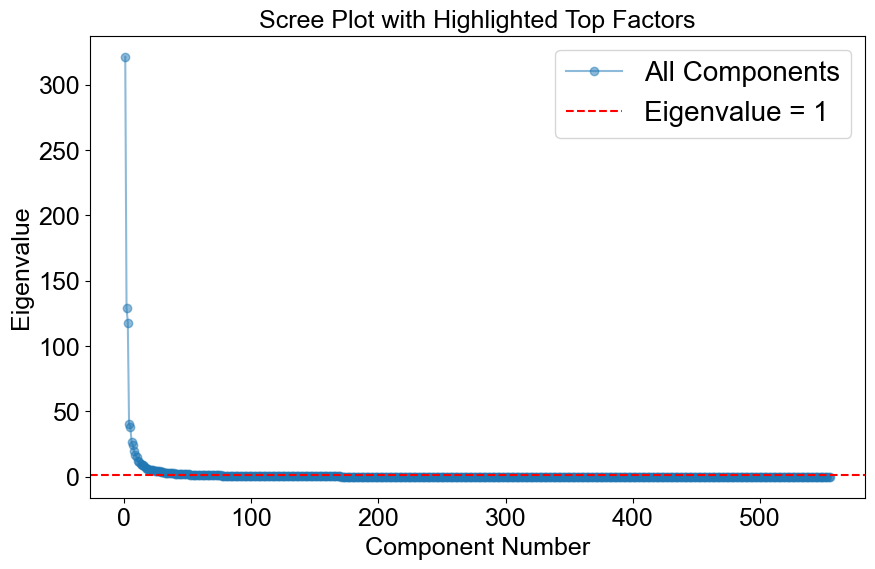

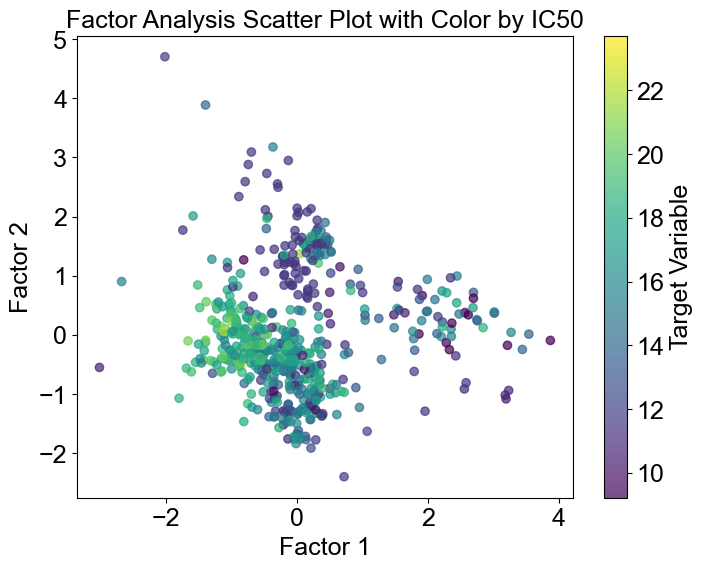

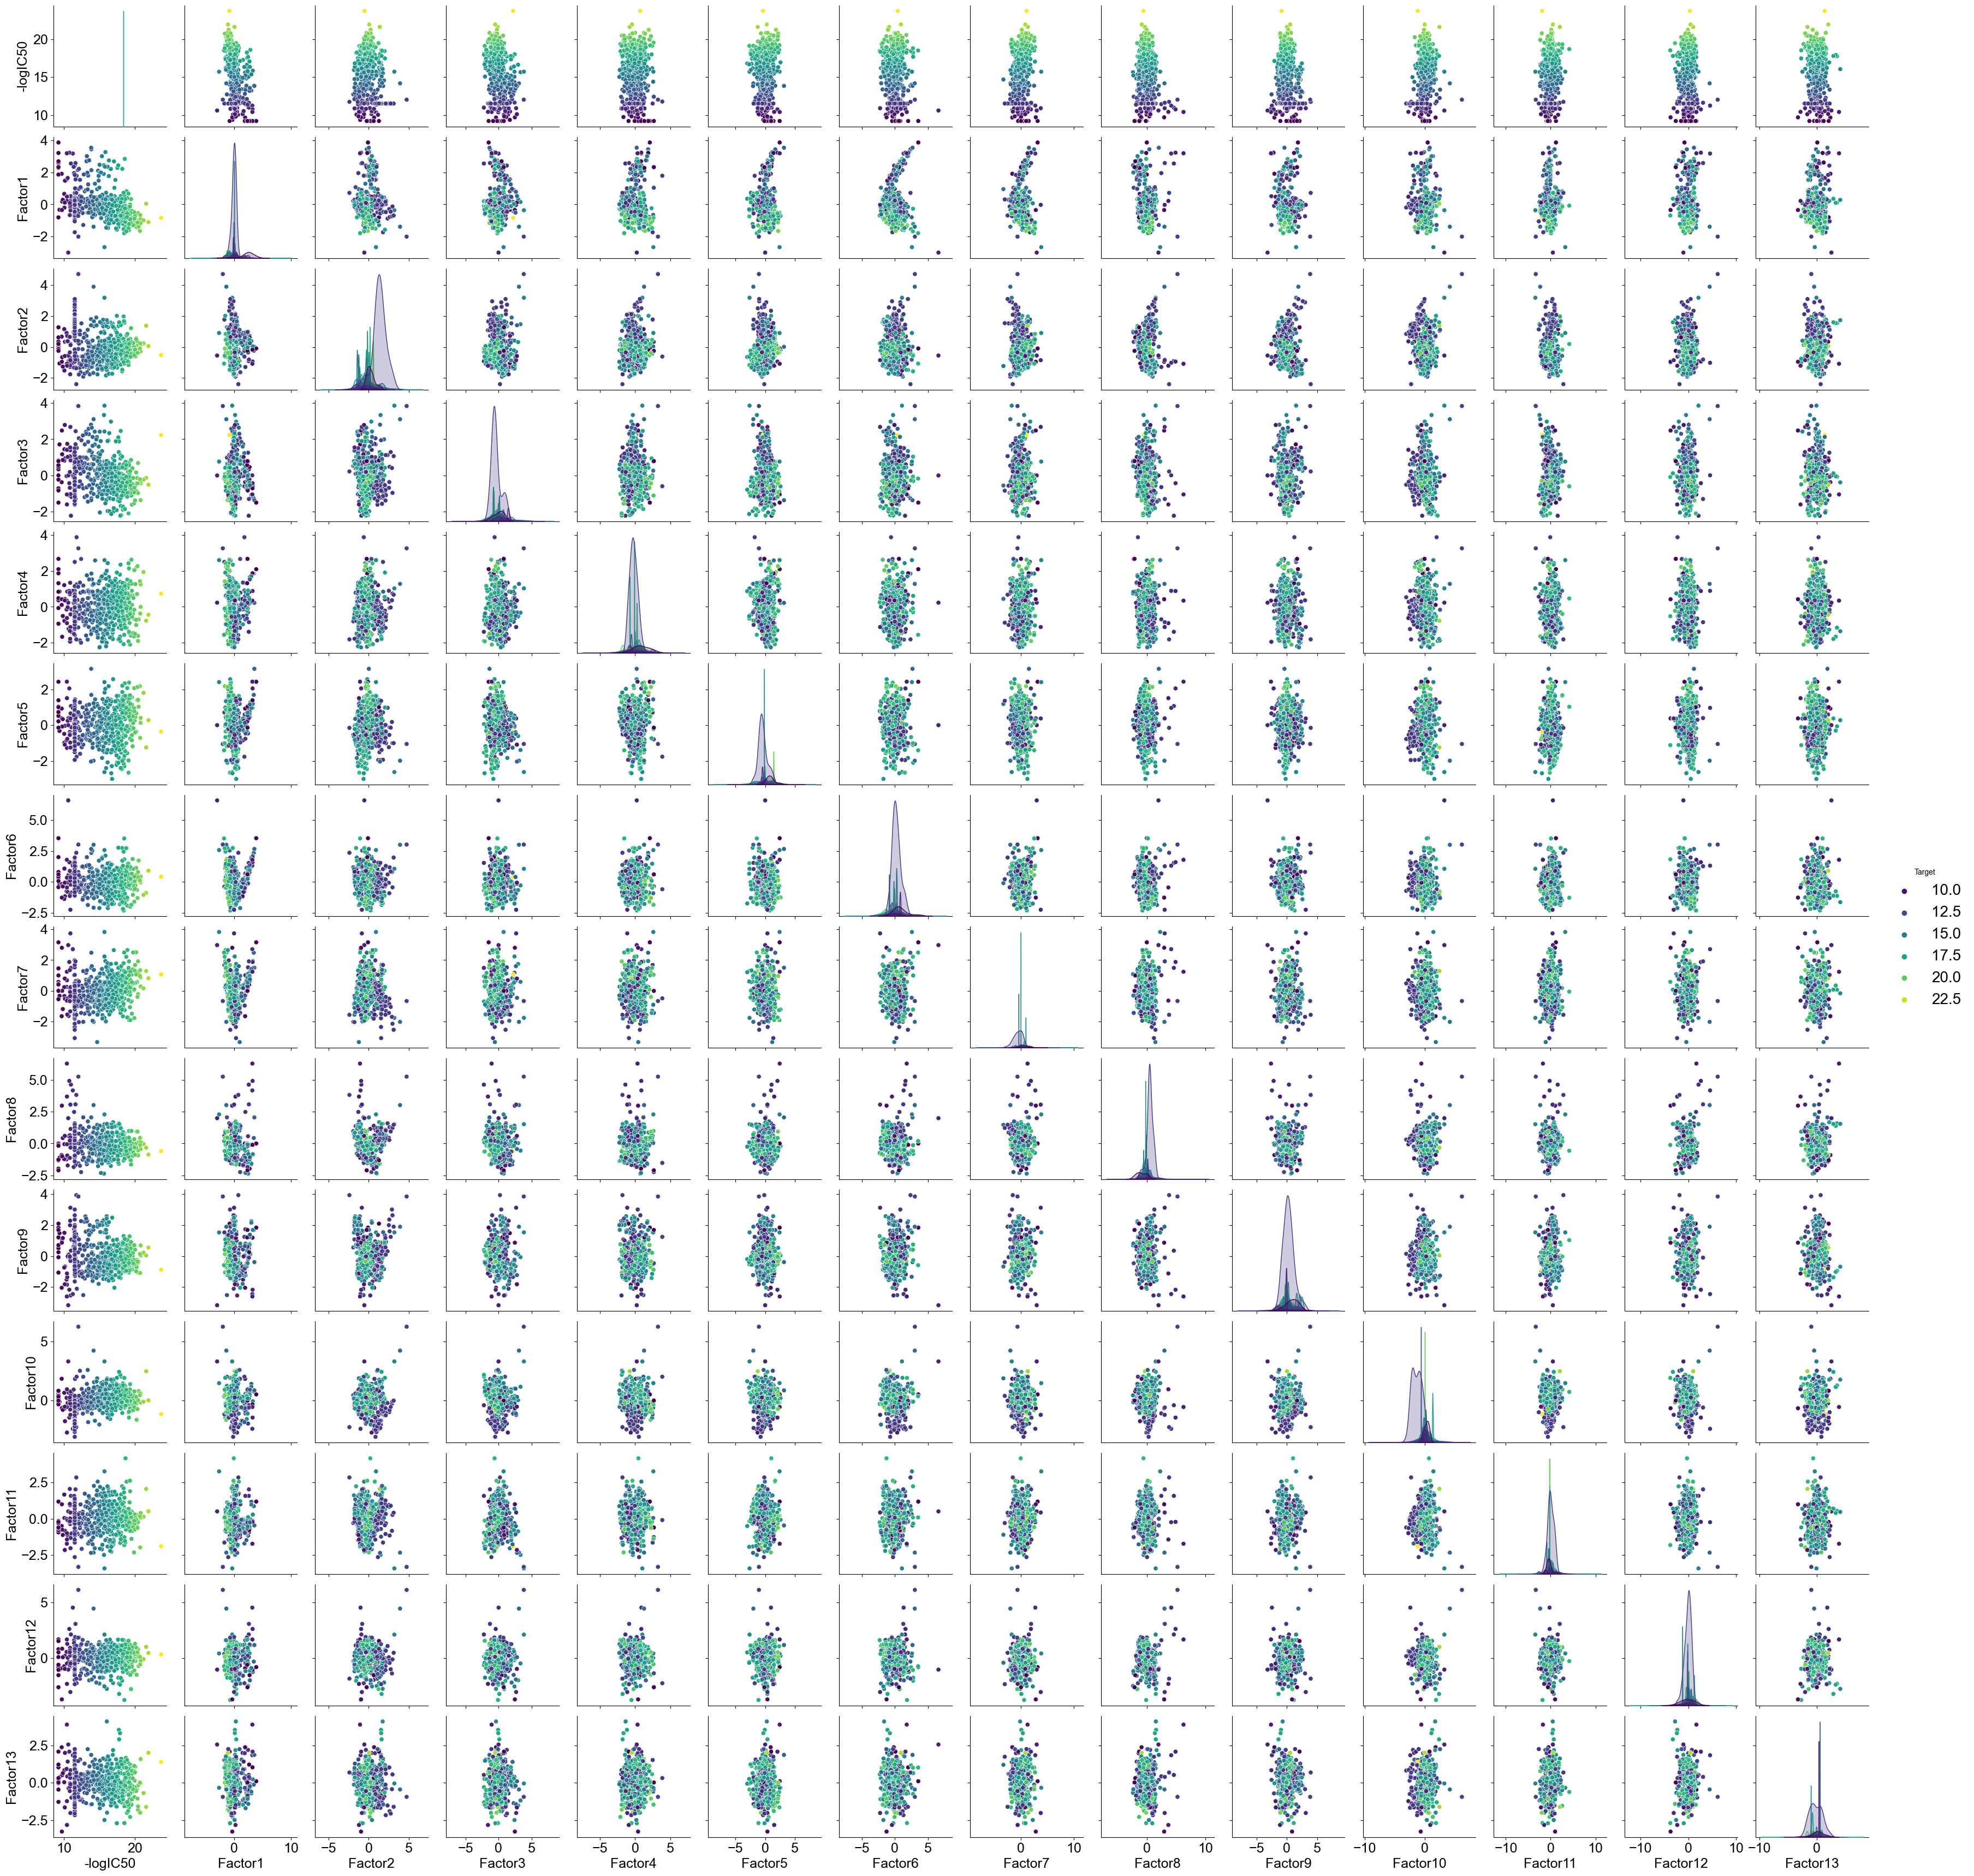

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure global font settings to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['axes.titlesize'] = 18  # Font size for titles
rcParams['axes.labelsize'] = 18  # Font size for axis labels
rcParams['xtick.labelsize'] = 18  # Font size for tick labels
rcParams['ytick.labelsize'] = 18  # Font size for tick labels
rcParams['legend.fontsize'] = 20  # Adjust legend font size

# 1. Load data
data = pd.read_csv("input/train_reg_nofilter_wIC50.csv")

# Separate features and target variable
X = data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])  # Replace '-logIC50' with your target variable if needed
y = data['-logIC50']  # Target variable

# 2. Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 3. Apply Factor Analysis
num_factors = 15  # Set the number of factors based on scree plot or domain knowledge
fa = FactorAnalysis(n_components=num_factors, random_state=42)
X_factors = fa.fit_transform(X_scaled)

# 4. Approximate Explained Variance (since FA doesn't directly provide it)
explained_variance = np.var(X_factors, axis=0) / np.sum(np.var(X_factors, axis=0))
print("Explained Variance by Factor:", explained_variance)
print(f"Number of factors selected: {num_factors}")

# 5. Inspect Factor Loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=X.columns, columns=[f'Factor{i+1}' for i in range(num_factors)])
print("Factor Loadings:\n", factor_loadings)

# 6. Dynamic Thresholding for Feature Selection
# Compute the absolute sum of loadings for each feature across all factors
abs_sum_loadings = factor_loadings.abs().sum(axis=1)

# Compute mean and standard deviation
mean_loading = abs_sum_loadings.mean()
std_loading = abs_sum_loadings.std()

# Define threshold: mean + 1.5 std
threshold = mean_loading + 1 * std_loading
print(f"Dynamic threshold (mean + 1 std): {threshold}")

# Select features based on the threshold
selected_features = abs_sum_loadings[abs_sum_loadings > threshold].index.tolist()
print(f"Number of features selected with threshold {threshold}: {len(selected_features)}")

# Save sorted absolute sums and selected features
abs_sum_loadings.sort_values(ascending=False).to_csv("FA_sorted_abs_sum_loadings.csv", header=True)
selected_columns = ['Molecule ChEMBL ID', '-logIC50'] + selected_features
selected_features_df = data[selected_columns]
selected_features_df.to_csv("FA_reg_selected_features_based_on_absolute_sum.csv", index=False)
print("Selected features saved to 'FA_reg_selected_features_based_on_absolute_sum.csv'.")

# 7. Save Transformed Factor Data
X_factors_df = pd.DataFrame(X_factors, columns=[f'Factor{i+1}' for i in range(num_factors)])
X_factors_df.insert(0, 'Molecule ChEMBL ID', data['Molecule ChEMBL ID'])
X_factors_df.insert(1, '-logIC50', data['-logIC50'])

X_factors_df.to_csv("FA_transformed_reduced_dim_data.csv", index=False)
print("Factor Analysis-transformed data saved to 'FA_transformed_reduced_dim_data.csv'.")

# 8. Scree Plot of Eigenvalues (using PCA as proxy)
from sklearn.decomposition import PCA
pca = PCA().fit(X_scaled)
eigenvalues = pca.explained_variance_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label="All Components", alpha=0.5)
plt.axhline(y=1, color='red', linestyle='--', label="Eigenvalue = 1")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot with Highlighted Top Factors")
plt.legend()
plt.savefig("FA_Scree_plot.png", format='png', dpi=300)
plt.show()

# 10. Factor Scatter Plot by Target Variable
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_factors_df['Factor1'], X_factors_df['Factor2'], c=y, cmap='viridis', alpha=0.7)
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("Factor Analysis Scatter Plot with Color by IC50")
plt.colorbar(scatter, label="Target Variable")
plt.savefig('FA_scatter_plot.svg', format='svg', dpi=300)
plt.show()

# 11. Pair Plot of Top Factors
factor_top_components = X_factors_df.iloc[:, :15]
factor_top_components['Target'] = y

pair_plot = sns.pairplot(factor_top_components, hue='Target', palette='viridis', diag_kind='kde')
pair_plot.fig.savefig("FA_all_15Factors_combinations.svg", format='svg', dpi=300)
plt.show()
